# Computing the nonadiabatic couplings in Kohn-Sham and excited states bases

In this tutorial, we will start computing the nonadiabatic couplings (NACs) from the molecular orbital overlap files obtained in [step2](../../7_step2_cp2k/1_DFT). The NACs will be computed in Kohn-Sham states and also in both single-partcile (SP) and many-body (MB) excited state bases. We will plot the NAC map and distribution and plotting the average density of states, excitation analysis, energy vs time, and influence spectrum are brought in [this tutorial](../../../../11_program_specific_methods/3_cp2k_methods).

## Table of contents
<a name="toc"></a>
1. [Importing needed libraries](#import)
2. [Overview of required files](#required_files)
3. [Computing NACs](#comp_nacs)     \
   3.1. [Kohn-Sham basis](#KS)\
   3.2. [Excited state basis](#excited_states)
4. [Plot results](#plot_res)\
   4.1. [Energy vs time](#ene_time)\
   4.2. [Average density of states](#ave_pdos)\
   4.3. [NAC map](#nac_map)\
   4.4. [NAC distribution](#nac_dist)\
   4.5. [Influence spectrum](#inf_spec)
   

### A. Learning objectives

* To be able to compute NACs in Kohn-Sham and excited state bases
* To be able to plot the computed excited states energies vs time
* To be able to plot the average partial density of states
* To be able to plot the NAC maps and distributions
* To be able to compute and plot the influence spectrum

### B. Use cases

* [Computing NACs](#comp_nacs)
* [Plot results](#plot_res)

### C. Functions

- `libra_py`
  - `data_stat`
    - [`cmat_distrib`](#nac_dist)
  - `influence_spectrum`
    - [`recipe1`](#inf_spec)
  - `workflows`
    - `nbra`
      - [`step3`](#comp_nacs)
        - [`run_step3_ks_nacs_libint`](#KS)
        - [`run_step3_sd_nacs_libint`](#excited_states)
  - `units`
    - `au2ev`

## 1. Importing needed libraries <a name="import"></a>
[Back to TOC](#toc)

Import `glob`, `numpy`, `scipy.sparse`, `matplotlib.pyplot`, and `step3` module which is used to compute the NACs in Kohn-Sham basis using `run_step3_ks_nacs_libint` and in excited states basis using `run_step3_sd_nacs_libint`. 

In [1]:
import os
import glob
import numpy as np
import scipy.sparse as sp
from libra_py import units, data_stat, influence_spectrum
import matplotlib.pyplot as plt
from liblibra_core import *
from libra_py.workflows.nbra import step3
import libra_py.packages.cp2k.methods as CP2K_methods

/home/98722002/miniconda3/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/98722002/miniconda3/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/98722002/miniconda3/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<float,

## 2. Overview of required files <a name="required_files"></a>
[Back to TOC](#toc)

* `../../7_step2_cp2k/1_DFT/2_hpc/1_example_TiO2/res`

The MO overlap files are needed and stored in this folder.

* `../../7_step2_cp2k/1_DFT/2_hpc/1_example_TiO2/all_logfiles`

All of the logfiles obtained from the electronic structure calculations of CP2K. These files will be needed to find the Kohn-Sham HOMO index and also extract the the TD-DFT data for each step.

## 3. Computing NACs <a name="comp_nacs"></a>
[Back to TOC](#toc)

### 3.1. Kohn-Sham basis <a name="KS"></a>

The `libra_py.workflow.nbra.step3.run_step3_ks_nacs_libint(params)` computes the NACs between pairs of Kohn-Sham states using the molecular orbitals time-overlaps. 


With no spin-orbit couplings, two blocks of the matrix is zero. Since most of the elements of the overlap matrices are zero, we use the `scipy.sparse` library for storing and loading them. 

The paramters for this function are as follows:

`params['lowest_orbital']`: The lowest orbital considered in the computation of the MO overlaps. This value is exactly the same
as in the `run_template.py` file in step2.

`params['highest_orbital']`: The highest orbital considered in the computation of the MO overlaps. This value is exactly the same
as in the `run_template.py` file in step2.

`params['num_occ_states']`: The number of occupied orbitals to be considered from HOMO to lower occupied states. This value is defined by user.

`params['num_unocc_states']`: The number of unoccupied orbitals to be considered from LUMO to higher unoccupied states. This value is defined by user.

The two values above are used to create an active space which then will be used to select the elements from the MO overlap and 
energy matrices. 

`params['use_multiprocessing']`: A boolean flag to use the multiprocessing library of Python or not.

`params['nprocs']`: The number of processors to be used for the calculations. Libra will use this only if the `params['use_multiprocessing']` 
is set to `True`.

`params['time_step']`: The time-step used in the calculations in `fs`.

`params['es_software']`: The name of the software package used to compute the electronic structure calculations. This will be used to generate the HOMO 
index of that system so it can build the active space.

`params['path_to_npz_files']`: The full path to the MO overlap files.

`params['logfile_directory']`: The full path to the folder where all the log files are stored.

`params['path_to_save_ks_Hvibs']`: The full path to the folder in which the NACs between the Konh-Sham states are stored.

`params['start_time']`: The start time-step.

`params['finish_time']`: The finish time-step.


After setting all the above paramters, the calculations are run using `step3.run_step3_ks_nacs_libint(params)`.


In [2]:
params_ks = {
              'lowest_orbital': 160-30, 'highest_orbital': 161+30, 'num_occ_states': 30, 'num_unocc_states': 30,
              'use_multiprocessing': True, 'nprocs': 32, 'time_step': 1.0, 'es_software': 'cp2k',
              'path_to_npz_files': os.getcwd()+'/../../03-OVERLAPS/pristine/2000-4000/res',
              'logfile_directory': os.getcwd()+'/../../03-OVERLAPS/pristine/2000-4000/all_logfiles',
              'path_to_save_ks_Hvibs': os.getcwd()+'/res-ks-DFT',
              'start_time': 2000, 'finish_time': 4000,
            }

# For KS orbitals
#step3.run_step3_ks_nacs_libint(params_ks)

### 3.2. Excited state basis <a name="excited_states"></a>
[Back to TOC](#toc)

Below, we will be using `step3.run_step3_sd_nacs_libint` function to compute the time-overlaps and nonadiabatic couplings between excited states basis. This can be done either in the many-body or single-particle basis. A schematic of the workflow for selecting new active space is shown below:


Some parameters are common with the ones used to run `step3.run_step3_ks_nacs_libint(params)` above.

Other parameters needed to run the `step3.run_step3_sd_nacs_libint(params)` function are as follows:

`params['isUKS']`: A boolean flag for unrestricted spin calculations.

`params['is_many_body']`: If set to `True`, the NACs will be computed between pairs of many-body (TD-DFT) states. Also, the NACs between single-particle 
SDs obtained from the TD-DFT results will be computed as well. Otherwise, only single-particle NACs will be computed only for the SDs obtained from
`num_occ_states` and `num_unocc_states`. This will be used for xTB calculations in which no TD-DFT was performed.

`params['number_of_states']`: The number of TD-DFT states to consider. This value should not exceed the number of requested TD-DFT states in the CP2K
calculations.

`params['tolerance']`: A lower bound for selection of the excitation with configuration interaction coefficients higher than this value.

`params['verbosity']`: An integer value showing the printing level. The default is set to 0. Higher values will print more data on the terminal.

`params['sorting_type']`: After defining the SDs, Libra will sort them either based on `'energy'` or `'identity'`.


The NACs can also be computed between excited states. These include the single-particle and many-body bases which the latter is obtained from the
TD-DFT calculations. First, we need to compute the overlap between excited state Slater-determinants (SDs) then they will be used to compute the NACs
between them. For many-body states, the configuration interaction coefficietns will be used. We will consider both single-particle 
and many-body for DFT calculations but only single-particle for xTB.

There are different ways of defining the excited states SDs (the single-particle excited state basis). The first is through 
defining the `num_occ_states` and `num_unocc_states` in which Libra
will start making the SDs from all of the occupied states (starting from `HOMO-num_occ_states+1`) to all of the unoccupied states (ends
to `LUMO+num_unocc_states-1`). Also, if the unrestricted spin calculation flag is set to `True`, the SDs will be made for both alpha and beta spin channels. 

For example, if you want to build the electron-only excitation basis, you need to set `params['num_occ_states'] = 1` and set `params['num_unocc_states']`
to a value less than the number of unoccupied orbitals that was considered in the computation of overlaps. This will generate all the electron-only
excitation from HOMO to unoccupied states.

If the TD-DFT calculations has been done, then Libra will go over all log files and 
generate all the SDs used for all the steps and therefore the definition of these SDs is automatic and Libra will replace the `num_occ_states` and
`num_unocc_states` itself based on the SDs that were generated from the TD-DFT log files. 



In [3]:
params_mb_sd = {
          'lowest_orbital': 160-30, 'highest_orbital': 161+30, 'num_occ_states': 30, 'num_unocc_states': 30,
          'isUKS': 0, 'number_of_states': 10, 'tolerance': 0.01, 'verbosity': 0, 'use_multiprocessing': True, 'nprocs': 32,
          'is_many_body': True, 'time_step': 1.0, 'es_software': 'cp2k',
              'path_to_npz_files': os.getcwd()+'/../../03-OVERLAPS/pristine/2000-4000/res',
              'logfile_directory': os.getcwd()+'/../../03-OVERLAPS/pristine/2000-4000/all_logfiles',
          'path_to_save_sd_Hvibs': os.getcwd()+'/res-mb-sd-DFT',
          'outdir': os.getcwd()+'/res-mb-sd-DFT', 'start_time': 2000, 'finish_time': 4000, 'sorting_type': 'identity',
         }

#step3.run_step3_sd_nacs_libint(params_mb_sd)

In [4]:
import os
import scipy.sparse as sp
import pandas as pd
# os.system("mkdir EXP-res-mb-sd-DFT")
# for i in range(2000,3998):
#     a=sp.load_npz("res-mb-sd-DFT/"+F"St_ci_{i}_re.npz").todense().real
#     a= np.array(a)
#     c=pd.DataFrame(a)
#     np.savetxt("EXP-res-mb-sd-DFT/"+F"St_ci_{i}_re", c, delimiter='  ')


## 4. Plot results <a name="plot_res"></a>
[Back to TOC](#toc)

### 4.1. Energy vs time <a name="ene_time"></a>

Here, we will plot the energies of single-particle and many-body excitation bases.

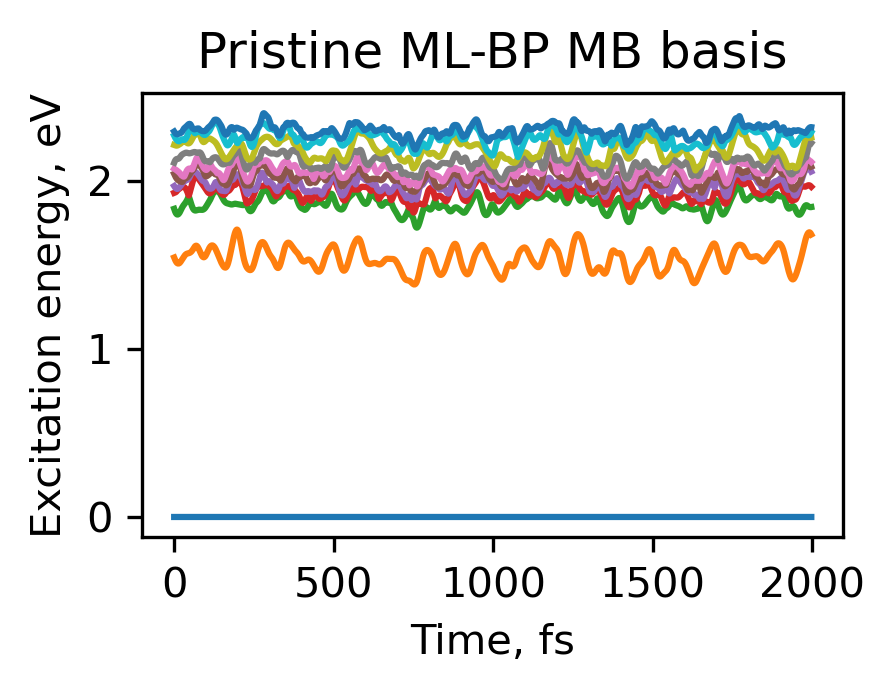

In [5]:
%matplotlib inline
plt.figure(num=None, figsize=(3.21*1, 2.41), dpi=300, edgecolor='black', frameon=True)

params = {"path_to_energy_files": "res-mb-sd-DFT", "dt": 1.0, 
          "prefix": "Hvib_sd_", "suffix": "_re", "istep": 2000, "fstep": 3998}

titles = ['Pristine ML-BP MB basis']
#plt.figure()
for c, basis in enumerate(['ci']):
    #plt.subplot(1,2,c+1)
    params.update({"prefix": F"Hvib_{basis}_"})
    md_time, energies = CP2K_methods.extract_energies_sparse(params)
    energies = energies * units.au2ev
    for i in range(energies.shape[1]):
        plt.plot(md_time, energies[:,i]-energies[:,0])
    
    plt.title(titles[c])
    plt.ylabel('Excitation energy, eV')
    plt.xlabel('Time, fs')
    #plt.ylim(-0.3, 7.3)
plt.tight_layout()
plt.savefig("Pristine_ML-BP_Excitation_mb_energy_Time.png", dpi=600)
plt.show()

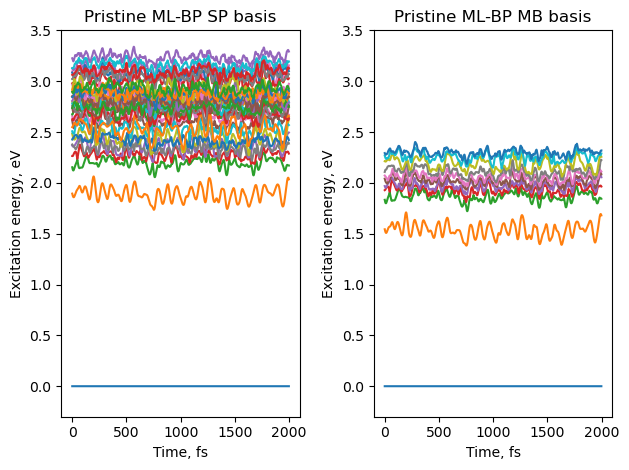

In [6]:
%matplotlib inline
#plt.figure(num=None, figsize=(3.21*1, 2.41), dpi=300, edgecolor='black', frameon=True)

params = {"path_to_energy_files": "res-mb-sd-DFT", "dt": 1.0, 
          "prefix": "Hvib_sd_", "suffix": "_re", "istep": 2000, "fstep": 3998}

titles = [ 'Pristine ML-BP SP basis','Pristine ML-BP MB basis']
#plt.figure()
for c, basis in enumerate(['sd','ci']):
    plt.subplot(1,2,c+1)
    params.update({"prefix": F"Hvib_{basis}_"})
    md_time, energies = CP2K_methods.extract_energies_sparse(params)
    energies = energies * units.au2ev
    for i in range(energies.shape[1]):
        plt.plot(md_time, energies[:,i]-energies[:,0])
        #print(energies[:,i]-energies[:,0])
    plt.title(titles[c])
    plt.ylabel('Excitation energy, eV')
    plt.xlabel('Time, fs')
    plt.ylim(-0.3, 3.5)
plt.tight_layout()
plt.savefig("Pristine_ML-BP_Excitation_sp-mb_energy_Time.png", dpi=600)
plt.show()

### 4.2. Average partial density of states <a name="ave_pdos"></a>
[Back to TOC](#toc)

In this section, we will plot the average partial density of states (pDOS) over the MD trajectory. There are two ways to take the average of the pDOS:

1- Average all the pDOS files and then convolve the average pDOS for each element.
2- Convolve the pDOS files and then take the average for each element.

We choose the first one due to two reasons. First, the computational cost is much lower and we only need one convolution. Second is that averaging over the grid points (using the method 2) is dependent on the number of grid points we use for convolution which again adds to the complexity of the procedure. 

Here, we will use normalized Gaussian function for weighting the pDOS values and summing them.

$$f(x)=\frac{1}{\sigma\sqrt{2\pi}}\exp(-\frac{(x-\mu)^2}{2\sigma^2})$$

This function is defined in the `CP2K_methods.gaussian_function`.

Now, we plot the pDOS for all of the angular momentum components of each atom. This is done by using the `orbital_cols`. In fact, the `orbital_cols` is related to `orbitals`. For example, for `s` orbital, we consider the 3rd index and for `p` orbital, we sum the columns from 4 to 6 (`range(4,7)`). Here we want to show how the code works and how the you can modify that based on your project. In the next section, we will show the pDOS only for atoms and sum all the components in each row of the pdos file. Other parameters are as follows:

`atoms`: The atoms names and numbers as appear in the `pdos` files which will be used in convolution, labeling and plotting. The atoms order should be exactly the same as appear in the `.pdos` files. For example, the `*k1*.pdos` files contain the pDOS data for `Ti` atom and `*k2*.pdos` files contain the data for the `O` atom. Therefore, we set `"atoms": [[1,2] , ['Ti', 'O']]`.

`npoints`: The number of grid points for making the Gaussian functions. Note that, this value should be more than the number of states in the `.pdos` files.

`sigma`: The standard deviation in eV.

`shift`: This value shifts the minimum and maximum energy found in the `pdos_ave` and will extend the boundaries from both sides by `shift`eV.

Finally, we will plot the total density of states. We manually set the HOMO energy level to zero.

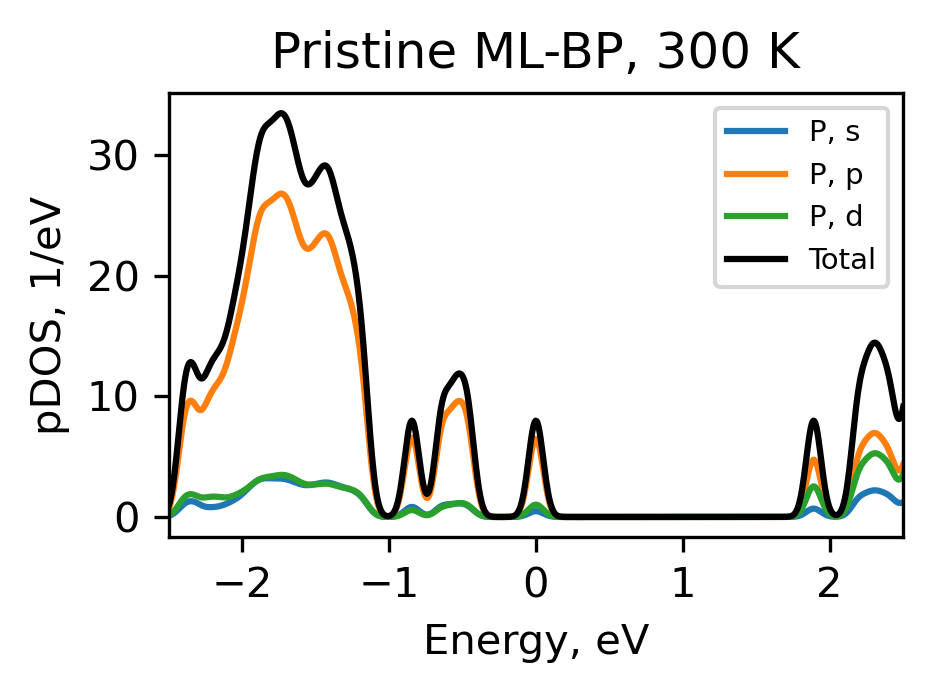

In [7]:
%matplotlib inline
plt.figure(num=None, figsize=(3.21*1, 2.41), dpi=300, edgecolor='black', frameon=True)

params = {"path_to_all_pdos": '../../03-OVERLAPS/pristine/2000-4000/all_pdosfiles', "atoms": [[1] , ['P']],
          "orbitals_cols": [[3], range(4,7), range(7,12)], "orbitals":  ['s','p','d'],
          "npoints": 4000, "sigma": 0.05, "shift": 2.0}

ave_energy_grid, homo_energy, ave_pdos_convolved, pdos_labels, ave_pdos_convolved_total = CP2K_methods.pdos(params)
for i in range(len(pdos_labels)):
    pdos_label = pdos_labels[i]
    plt.plot(ave_energy_grid-homo_energy, ave_pdos_convolved[i], label=pdos_label)
plt.plot(ave_energy_grid-homo_energy, ave_pdos_convolved_total, color='black', label='Total')
plt.legend(fontsize=7, ncol=1, loc='upper right')
plt.xlim(-2.5,2.5)
plt.ylabel('pDOS, 1/eV')
plt.xlabel('Energy, eV')
plt.title('Pristine ML-BP, 300 K')
plt.tight_layout()
plt.savefig("pDOS_Pristine_ML-BP.png", dpi=600)


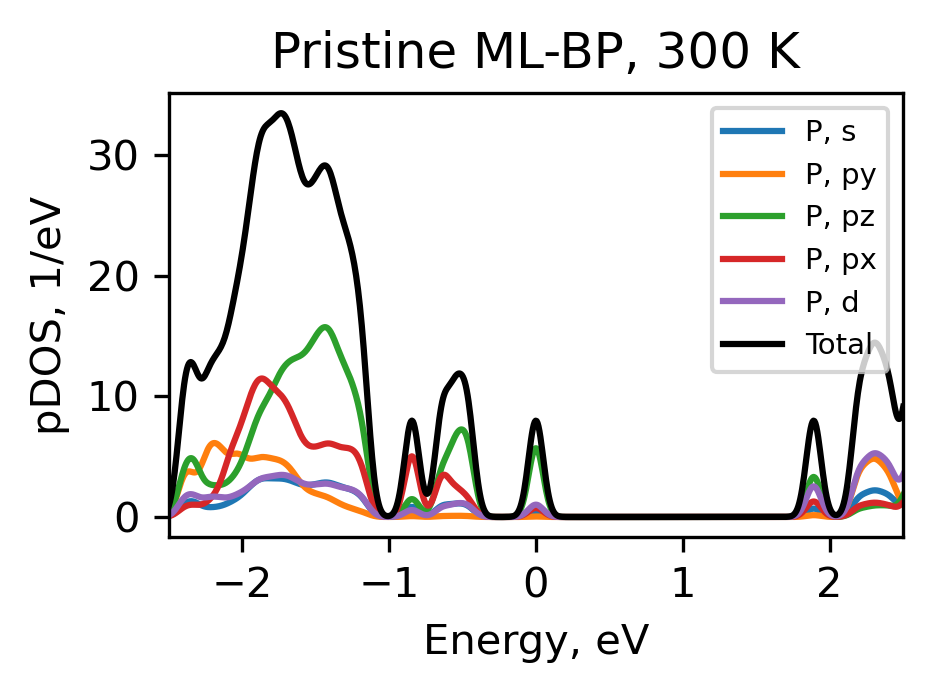

In [8]:
%matplotlib inline
plt.figure(num=None, figsize=(3.21*1, 2.41), dpi=300, edgecolor='black', frameon=True)

params = {"path_to_all_pdos": '../../03-OVERLAPS/pristine/2000-4000/all_pdosfiles', "atoms": [[1] , ['P']],
          "orbitals_cols": [[3], [4], [5], [6], range(7,12)], "orbitals":  ['s','py', 'pz', 'px','d'],
          "npoints": 4000, "sigma": 0.05, "shift": 2.0}

ave_energy_grid, homo_energy, ave_pdos_convolved, pdos_labels, ave_pdos_convolved_total = CP2K_methods.pdos(params)
for i in range(len(pdos_labels)):
    pdos_label = pdos_labels[i]
    plt.plot(ave_energy_grid-homo_energy, ave_pdos_convolved[i], label=pdos_label)
plt.plot(ave_energy_grid-homo_energy, ave_pdos_convolved_total, color='black', label='Total')
plt.legend(fontsize=7, ncol=1, loc='upper right')
plt.xlim(-2.5,2.5)
plt.ylabel('pDOS, 1/eV')
plt.xlabel('Energy, eV')
plt.title('Pristine ML-BP, 300 K')
plt.tight_layout()
plt.savefig("pDOS_Pristine_ML-BPP.png", dpi=600)


### 4.3. NAC map <a name="nac_map"></a>
[Back to TOC](#toc)

One way of visualizing the NAC values is to plot the average NAC matrix using `plt.imshow`. 

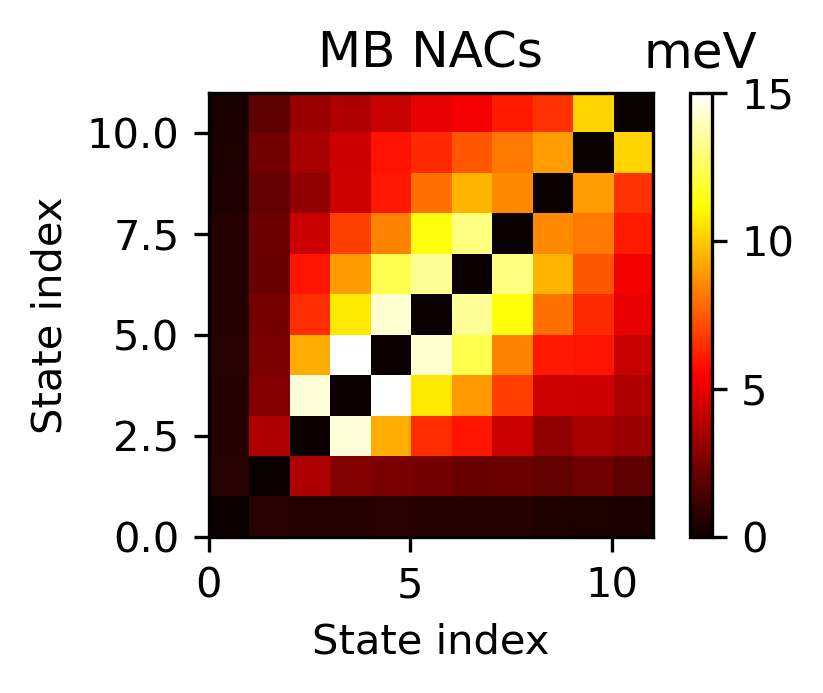

In [9]:
%matplotlib inline
plt.figure(num=None, figsize=(3.21*1, 2.41), dpi=300, edgecolor='black', frameon=True)
titles = ['MB']
for c1, basis in enumerate(['ci']):
    #plt.subplot(1, 2, c1+1)
    nac_files = glob.glob(F'res-mb-sd-DFT/Hvib_{basis}*im*')
    for c2, nac_file in enumerate(nac_files):
        nac_mat = sp.load_npz(nac_file).todense().real
        if c2==0:
            nac_ave = np.zeros(nac_mat.shape)
        nac_ave += np.abs(nac_mat)
    nac_ave *= 1000*units.au2ev/c2
    nstates = nac_ave.shape[0]
    plt.imshow(np.flipud(nac_ave), cmap='hot', extent=(0,nstates,0,nstates))#, vmin=0, vmax=100)
    plt.xlabel('State index')
    plt.ylabel('State index')
    colorbar = plt.colorbar()#shrink=0.50
    colorbar.ax.set_title('meV')
    plt.clim(vmin=0, vmax=15)
    plt.title(F'{titles[c1]} NACs')
    plt.tight_layout()
plt.savefig("nacs.png", dpi=600)
    

### 4.4. NAC distribution <a name="nac_dist"></a>
[Back to TOC](#toc)

Another intuitive way to visualize the NACs is to plot the distribution of the NACs. Here we plot them for SP and MB excited states. A smoother distribution plot is obtained if more steps are involved.

`data_stat.cmat_distrib` is used for computing the distribution of the NAC magnitudes within the range of $0$ to $50$ meV.

In [10]:
help(data_stat.cmat_distrib)

Help on function cmat_distrib in module libra_py.data_stat:

cmat_distrib(X, i, j, component, xmin, xmax, dx)
    Computes the distribution of the matrix element values in the list of CMATRIX(N,N) objects
    
    Args:
        X ( list of CMATRIX(N,N) objects ): the data to be analyzed
        i ( int ): row index of the matrix element to analyze
        j ( int ): column index of the matrix element to analyze
        component ( int = 0 or 1 ): determines whether to analyze the real (0) or imaginary (1)
            component of the data series
        xmin ( double ): the minimal value of the bin support
        xmax ( double ): the maximal value of the bin support
        dx ( double ): the value of the bin support grid spacing
                    
    Returns:
        tuple: ( bin_support, dens, cum ), where:
    
            * bin_support ( list of doubles ): the range of values the distribution is computed for
            * dens ( list of doubles ): the probability density
      

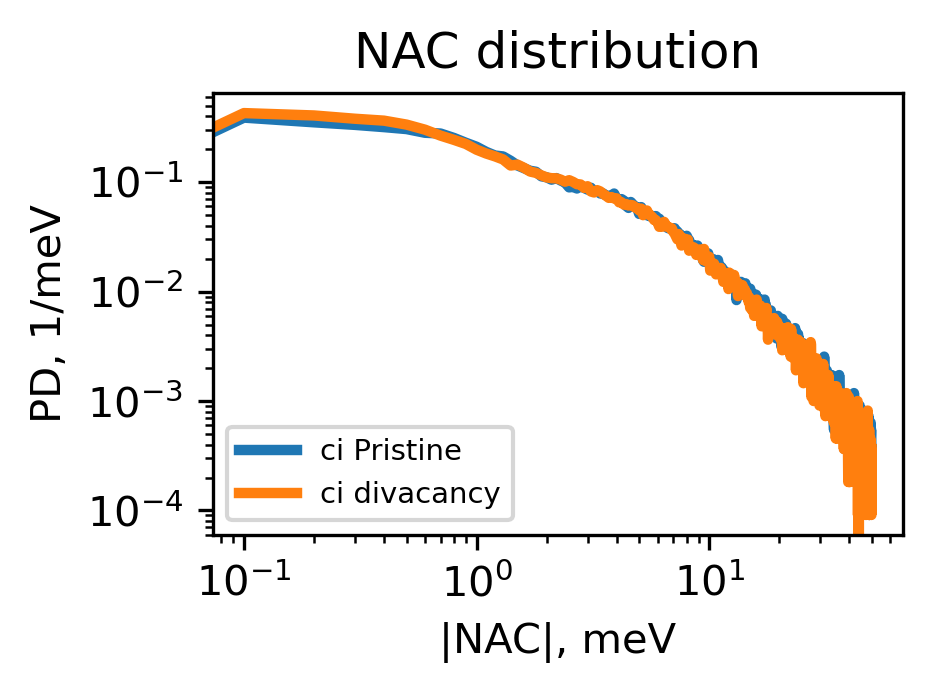

In [11]:
%matplotlib inline
plt.figure(num=None, figsize=(3.21*1, 2.41), dpi=300, edgecolor='black', frameon=True)

for basis in ['ci']:
    nac = []
    nac_files = glob.glob(F'res-mb-sd-DFT/Hvib_{basis}*im*')
    for nac_file in nac_files:
        hvib = sp.load_npz(nac_file)
        #print(hvib)
        hvib_dense = hvib.todense().real
        for i in range(hvib.shape[0]):
            for j in range(hvib.shape[0]):
                if j != i:
                    nac_ij = np.abs(hvib_dense[i,j])* 1000.0 * units.au2ev
                    x_mb = MATRIX(1,1)
                    x_mb.set(0, 0, nac_ij )
                    nac.append( x_mb )
    bin_supp1, dens1, cum = data_stat.cmat_distrib( nac, 0, 0, 0, 0, 50, 0.1)
    plt.plot( bin_supp1, dens1,linewidth=2.5, label=F'{basis} Pristine')
for basis in ['ci']:
    nac = []
    nac_files = glob.glob(F'../di_vacancy/res-mb-sd-DFT/Hvib_{basis}*im*')
    for nac_file in nac_files:
        hvib = sp.load_npz(nac_file)
        #print(hvib)
        hvib_dense = hvib.todense().real
        for i in range(hvib.shape[0]):
            for j in range(hvib.shape[0]):
                if j != i:
                    nac_ij = np.abs(hvib_dense[i,j])* 1000.0 * units.au2ev
                    x_mb = MATRIX(1,1)
                    x_mb.set(0, 0, nac_ij )
                    nac.append( x_mb )
    bin_supp2, dens2, cum = data_stat.cmat_distrib( nac, 0, 0, 0, 0, 50, 0.1)
    plt.plot( bin_supp2, dens2,linewidth=2.5, label=F'{basis} divacancy')    
    
plt.xlabel('|NAC|, meV')
plt.ylabel('PD, 1/meV')
plt.title('NAC distribution')#, SP vs MB')
plt.legend(fontsize=7)
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.savefig('nac_dist.png', dpi=600)

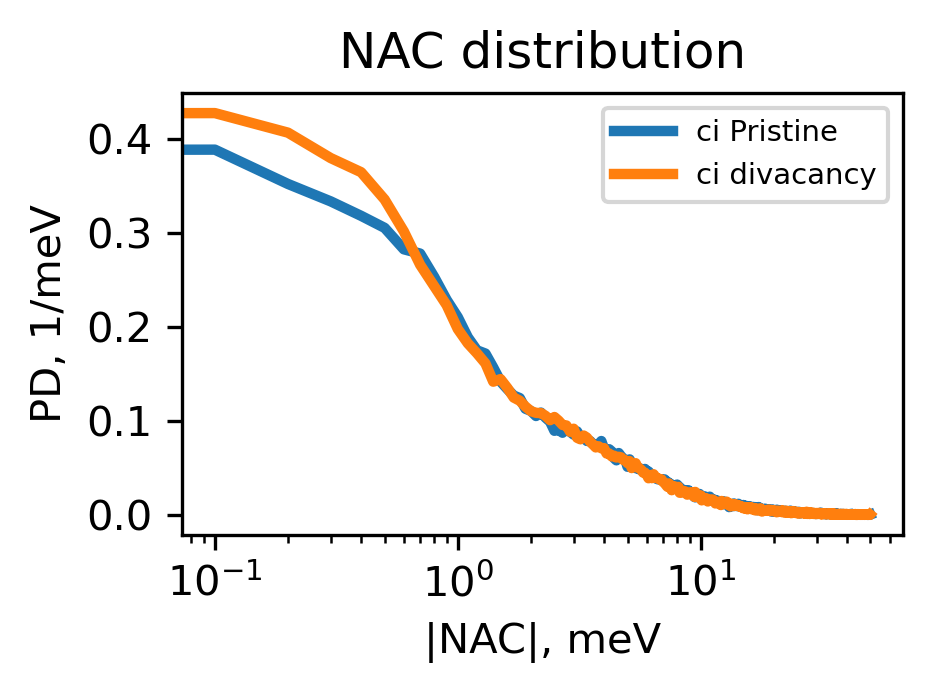

In [12]:
%matplotlib inline
plt.figure(num=None, figsize=(3.21*1, 2.41), dpi=300, edgecolor='black', frameon=True)

for basis in ['ci']:
    nac = []
    nac_files = glob.glob(F'res-mb-sd-DFT/Hvib_{basis}*im*')
    for nac_file in nac_files:
        hvib = sp.load_npz(nac_file)
        #print(hvib)
        hvib_dense = hvib.todense().real
        for i in range(hvib.shape[0]):
            for j in range(hvib.shape[0]):
                if j != i:
                    nac_ij = np.abs(hvib_dense[i,j])* 1000.0 * units.au2ev
                    x_mb = MATRIX(1,1)
                    x_mb.set(0, 0, nac_ij )
                    nac.append( x_mb )
    bin_supp1, dens1, cum = data_stat.cmat_distrib( nac, 0, 0, 0, 0, 50, 0.1)
    plt.plot( bin_supp1, dens1, linewidth=2.5, label=F'{basis} Pristine')
for basis in ['ci']:
    nac = []
    nac_files = glob.glob(F'../di_vacancy/res-mb-sd-DFT/Hvib_{basis}*im*')
    for nac_file in nac_files:
        hvib = sp.load_npz(nac_file)
        #print(hvib)
        hvib_dense = hvib.todense().real
        for i in range(hvib.shape[0]):
            for j in range(hvib.shape[0]):
                if j != i:
                    nac_ij = np.abs(hvib_dense[i,j])* 1000.0 * units.au2ev
                    x_mb = MATRIX(1,1)
                    x_mb.set(0, 0, nac_ij )
                    nac.append( x_mb )
    bin_supp2, dens2, cum = data_stat.cmat_distrib( nac, 0, 0, 0, 0, 50, 0.1)
    plt.plot( bin_supp2, dens2, linewidth=2.5, label=F'{basis} divacancy')    
    
plt.xlabel('|NAC|, meV')
plt.ylabel('PD, 1/meV')
plt.title('NAC distribution')#, SP vs MB')
plt.legend(fontsize=7)
plt.xscale('log')
plt.yscale('linear')
plt.tight_layout()
plt.savefig('nac_dist_y_linear.png', dpi=600)

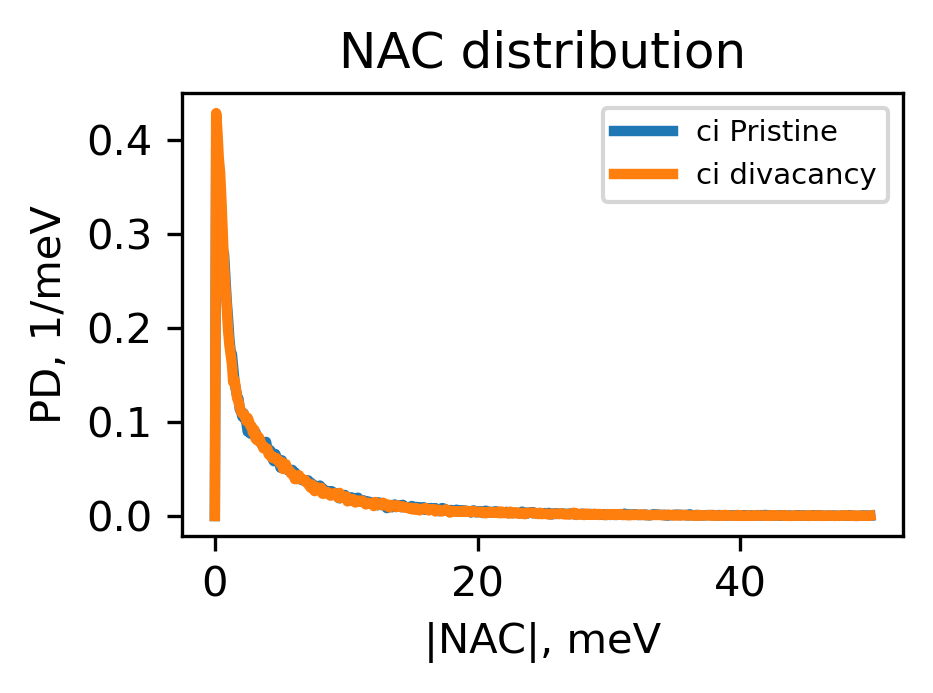

In [13]:
%matplotlib inline
plt.figure(num=None, figsize=(3.21*1, 2.41), dpi=300, edgecolor='black', frameon=True)

for basis in ['ci']:
    nac = []
    nac_files = glob.glob(F'res-mb-sd-DFT/Hvib_{basis}*im*')
    for nac_file in nac_files:
        hvib = sp.load_npz(nac_file)
        #print(hvib)
        hvib_dense = hvib.todense().real
        for i in range(hvib.shape[0]):
            for j in range(hvib.shape[0]):
                if j != i:
                    nac_ij = np.abs(hvib_dense[i,j])* 1000.0 * units.au2ev
                    x_mb = MATRIX(1,1)
                    x_mb.set(0, 0, nac_ij )
                    nac.append( x_mb )
    bin_supp1, dens1, cum = data_stat.cmat_distrib( nac, 0, 0, 0, 0, 50, 0.1)
    plt.plot( bin_supp1, dens1,linewidth=2.5, label=F'{basis} Pristine')
for basis in ['ci']:
    nac = []
    nac_files = glob.glob(F'../di_vacancy/res-mb-sd-DFT/Hvib_{basis}*im*')
    for nac_file in nac_files:
        hvib = sp.load_npz(nac_file)
        #print(hvib)
        hvib_dense = hvib.todense().real
        for i in range(hvib.shape[0]):
            for j in range(hvib.shape[0]):
                if j != i:
                    nac_ij = np.abs(hvib_dense[i,j])* 1000.0 * units.au2ev
                    x_mb = MATRIX(1,1)
                    x_mb.set(0, 0, nac_ij )
                    nac.append( x_mb )
    bin_supp2, dens2, cum = data_stat.cmat_distrib( nac, 0, 0, 0, 0, 50, 0.1)
    plt.plot( bin_supp2, dens2,linewidth=2.5,label=F'{basis} divacancy')    
    
plt.xlabel('|NAC|, meV')
plt.ylabel('PD, 1/meV')
plt.title('NAC distribution')#, SP vs MB')
plt.legend(fontsize=7)
plt.xscale('linear')
plt.yscale('linear')
plt.tight_layout()
plt.savefig('nac_dist_xy_linear.png', dpi=600)

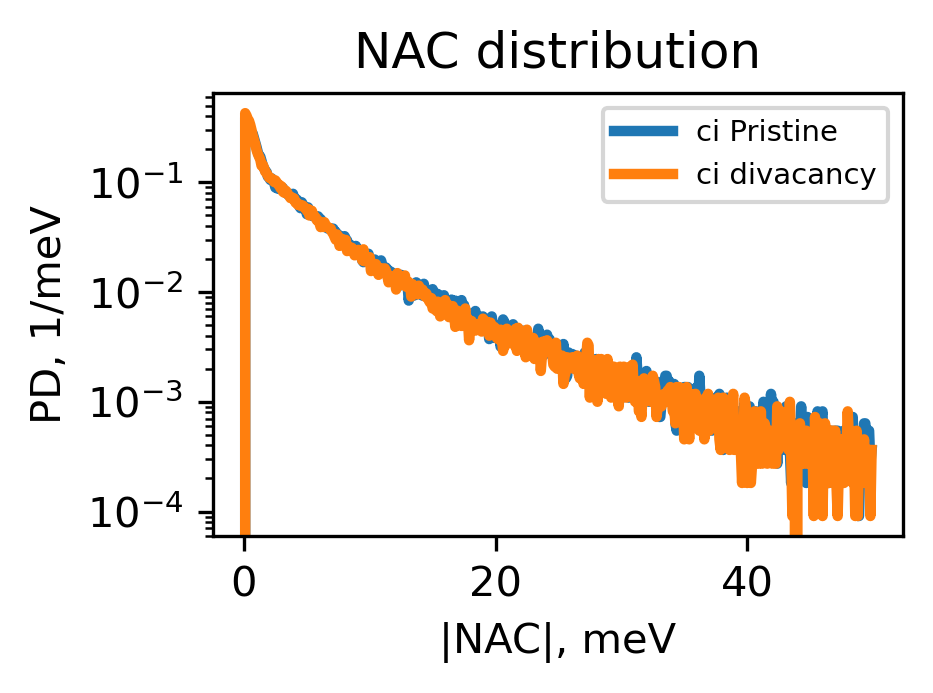

In [14]:
%matplotlib inline
plt.figure(num=None, figsize=(3.21*1, 2.41), dpi=300, edgecolor='black', frameon=True)

for basis in ['ci']:
    nac = []
    nac_files = glob.glob(F'res-mb-sd-DFT/Hvib_{basis}*im*')
    for nac_file in nac_files:
        hvib = sp.load_npz(nac_file)
        #print(hvib)
        hvib_dense = hvib.todense().real
        for i in range(hvib.shape[0]):
            for j in range(hvib.shape[0]):
                if j != i:
                    nac_ij = np.abs(hvib_dense[i,j])* 1000.0 * units.au2ev
                    x_mb = MATRIX(1,1)
                    x_mb.set(0, 0, nac_ij )
                    nac.append( x_mb )
    bin_supp1, dens1, cum = data_stat.cmat_distrib( nac, 0, 0, 0, 0, 50, 0.1)
    plt.plot( bin_supp1, dens1,linewidth=2.5, label=F'{basis} Pristine')
for basis in ['ci']:
    nac = []
    nac_files = glob.glob(F'../di_vacancy/res-mb-sd-DFT/Hvib_{basis}*im*')
    for nac_file in nac_files:
        hvib = sp.load_npz(nac_file)
        #print(hvib)
        hvib_dense = hvib.todense().real
        for i in range(hvib.shape[0]):
            for j in range(hvib.shape[0]):
                if j != i:
                    nac_ij = np.abs(hvib_dense[i,j])* 1000.0 * units.au2ev
                    x_mb = MATRIX(1,1)
                    x_mb.set(0, 0, nac_ij )
                    nac.append( x_mb )
    bin_supp2, dens2, cum = data_stat.cmat_distrib( nac, 0, 0, 0, 0, 50, 0.1)
    plt.plot( bin_supp2, dens2,linewidth=2.5, label=F'{basis} divacancy')    
    
plt.xlabel('|NAC|, meV')
plt.ylabel('PD, 1/meV')
plt.title('NAC distribution')#, SP vs MB')
plt.legend(fontsize=7)
plt.xscale('linear')
plt.yscale('log')
plt.tight_layout()
plt.savefig('nac_dist_x_linear.png', dpi=600)

### 4.5. Influence spectrum <a name="inf_spec"></a>
[Back to TOC](#toc)


In order to compute the influence spectrum for the energy gap fluctuations between two states, `i` and `j`. The parameters that need to be passed to the function `influence_spectrum.recipe1` are as follows:

`data`: A list of `MATRIX(ndof, 1)` objects i.e. a sequence of real-valued ndof-dimensional vectors

`dt`: Time step in fs units
    
`wspan`: The window of frequencies for the Fourier transform with units cm$^{-1}$

`dw`: The grid points spacing in the frequency domain with units of cm$^{-1}$

`do_output`: Whether we print out the data the results into files

`acf_filename`: The name of the file where to print the ACF
    
`spectrum_filename`: The name of the file where to print the spectrum 

`do_center`: A flag controlling whether to center data (=`True`) or not (=`False`). Centering means we subtract the average value (over all the data points) from all the data points - this way, we convert values into their fluctuations 

`acf_type`: selector of the convention to to compute ACF:
```
   * 0 : the chemist convention,  (1/(N-h)) Sum_{t=1,N-h} (Y[t]*Y[t+h]) [ default ]
   * 1 : the statistician convention, (1/N) Sum_{t=1,N-h} (Y[t]*Y[t+h])
```

`data_type`: What is the format of the data?
```
        * 0 : list of MATRIX(ndof, 1) [ default ]
        * 1 : list of VECTOR
```

The `recipe1` function returns a tuple of (T, norm_acf, raw_acf, W, J, J2), where:

`T`: List with time axis in `fs` units

`norm_acf`: List with normalized ACF

`raw_acf`: List with un-normalized ACF

`W`: List with frequencies axis with units $cm^{-1}$

`J`: List with amplitudes of Fourier transform

`J2`: List with values of $(1/2\pi)|J|^2$

Select two states of interest to compute the influence spectrum for their energy gap fluctuations. Here we comute that for the ground state, `i=0`, and the first excited state, `j=1` and then plot the spectrum.

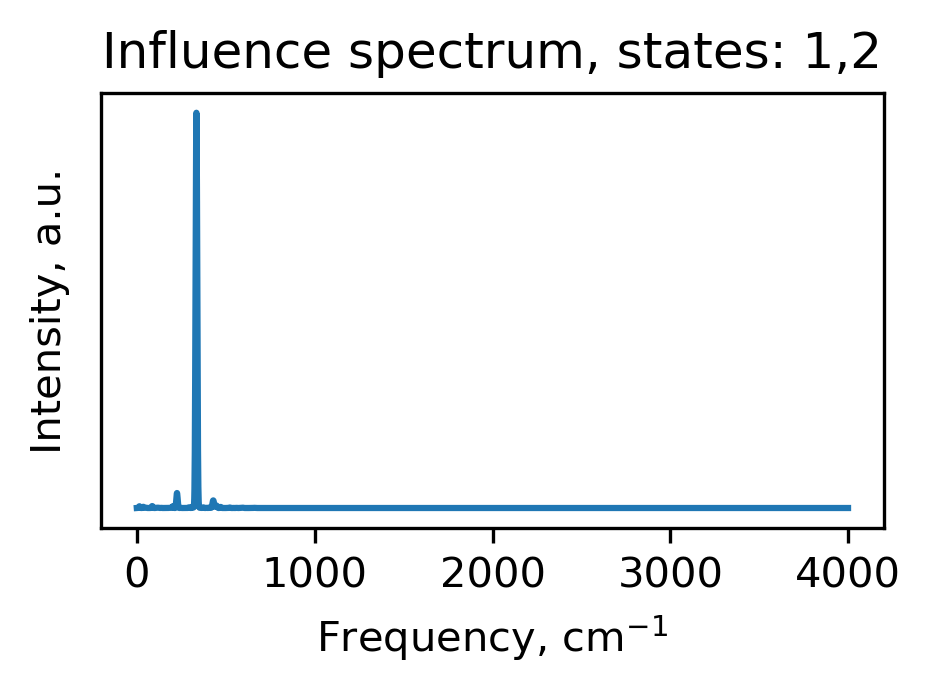

In [15]:
%matplotlib inline
plt.figure(num=None, figsize=(3.21*1, 2.41), dpi=300, edgecolor='black', frameon=True)

# For computing influence spectra
params_inf_cpec = {"dt": 1.0, "wspan": 4000.0, "dw": 1.0, "do_output": False,
          "do_center": True, "acf_type": 1, "data_type": 0}
# ==========
# Selecting the two states we want to compute the influence spectra for
i = 0; j = 1
i = 0; j = 2
i = 1; j = 2

# ========== Computing the autocorrelation function and the influence spectra
data_ij = []
for step in range(energies.shape[0]):
    x = MATRIX(1,1)
    if i<j:
        gap = energies[step,j]-energies[step,i]
    else:
        gap = energies[step,i]-energies[step,j]
    x.set(0,0, gap)
    data_ij.append(x)
Tij, ACFij, uACFij, Wij, Jij, J2ij = influence_spectrum.recipe1(data_ij, params_inf_cpec)

plt.plot(Wij, J2ij)
plt.xlabel('Frequency, cm$^{-1}$')
plt.ylabel('Intensity, a.u.')
plt.yticks([])
plt.title(F'Influence spectrum, states: {i},{j}')
plt.tight_layout()